In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf


In [3]:
import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'horses_or_humans',
    split=['train[:90%]', 'train[90%:]', 'test[:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


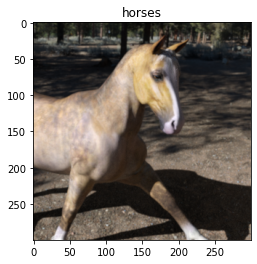

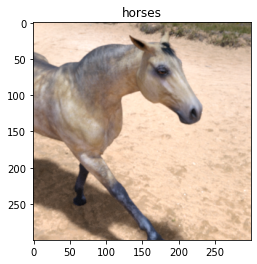

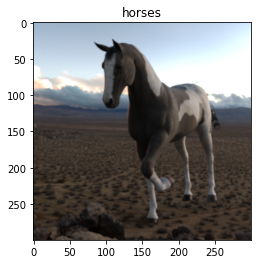

In [6]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [7]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
#   image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)
validation_batches = validation_batches.prefetch(buffer_size=AUTOTUNE)
test_batches = test_batches.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

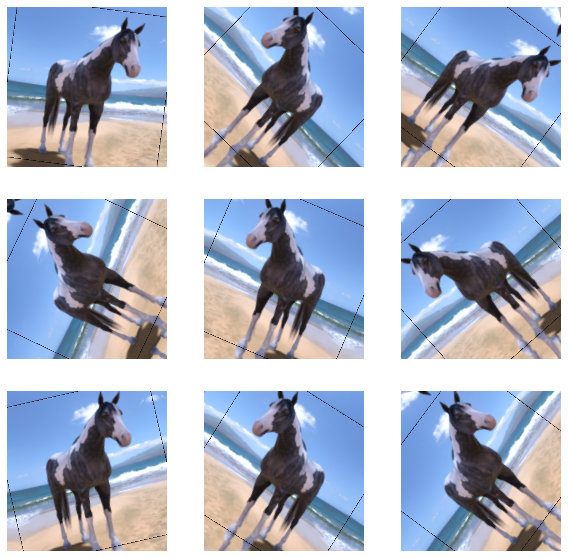

In [13]:
for image, _ in train_batches.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [15]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [16]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  311


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [18]:
image_batch, label_batch = next(iter(train_batches))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
dropout = tf.keras.layers.Dropout(0.5)
print(feature_batch_average.shape)

(32, 2048)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [26]:
len(model.trainable_variables)

2

In [27]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(test_batches)

8/8 [==============================] - 2s 242ms/step - loss: 1.0217 - accuracy: 0.3984


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.02
initial accuracy: 0.40


In [29]:
history = model.fit(train_batches, epochs=initial_epochs,validation_data=validation_batches)

Epoch 1/10
29/29 [==============================] - 9s 307ms/step - loss: 1.0765 - accuracy: 0.5400 - val_loss: 0.6288 - val_accuracy: 0.5631
Epoch 2/10
29/29 [==============================] - 9s 305ms/step - loss: 0.9053 - accuracy: 0.5833 - val_loss: 0.4696 - val_accuracy: 0.6408
Epoch 3/10
29/29 [==============================] - 9s 306ms/step - loss: 0.6311 - accuracy: 0.6905 - val_loss: 0.3716 - val_accuracy: 0.7087
Epoch 4/10
29/29 [==============================] - 9s 306ms/step - loss: 0.5771 - accuracy: 0.7316 - val_loss: 0.2962 - val_accuracy: 0.8058
Epoch 5/10
29/29 [==============================] - 9s 307ms/step - loss: 0.4872 - accuracy: 0.7771 - val_loss: 0.2430 - val_accuracy: 0.8350
Epoch 6/10
29/29 [==============================] - 9s 305ms/step - loss: 0.4637 - accuracy: 0.7835 - val_loss: 0.1832 - val_accuracy: 0.8835
Epoch 7/10
29/29 [==============================] - 9s 309ms/step - loss: 0.3941 - accuracy: 0.8182 - val_loss: 0.1556 - val_accuracy: 0.8932
Epoch 

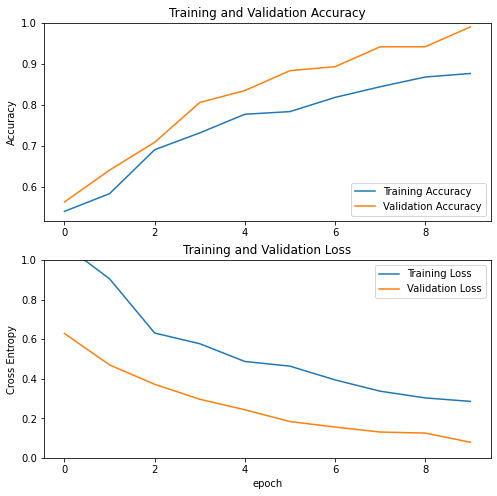

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
base_model.trainable = True


In [32]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer =  tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [35]:
len(model.trainable_variables)


136

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
29/29 [==============================] - 23s 803ms/step - loss: 0.1428 - accuracy: 0.9383 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 11/20
29/29 [==============================] - 22s 770ms/step - loss: 0.0485 - accuracy: 0.9794 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 12/20
29/29 [==============================] - 22s 772ms/step - loss: 0.0176 - accuracy: 0.9913 - val_loss: 4.6742e-04 - val_accuracy: 1.0000
Epoch 13/20
29/29 [==============================] - 22s 773ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 2.6766e-04 - val_accuracy: 1.0000
Epoch 14/20
29/29 [==============================] - 22s 772ms/step - loss: 0.0096 - accuracy: 0.9978 - val_loss: 6.5728e-05 - val_accuracy: 1.0000
Epoch 15/20
29/29 [==============================] - 22s 770ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 4.3104e-05 - val_accuracy: 1.0000
Epoch 16/20
29/29 [==============================] - 22s 771ms/step - loss: 0.0021 - accuracy: 0.9989 - val_loss: 1.3676

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

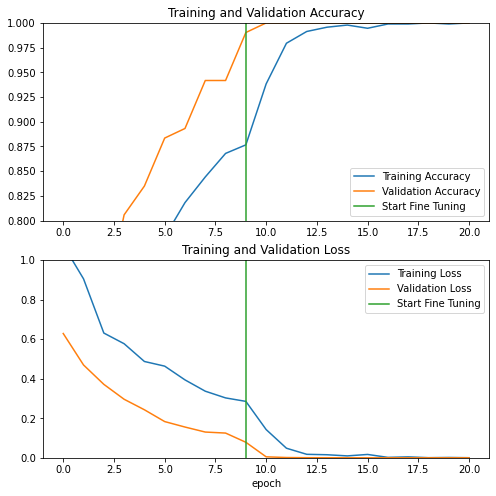

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)


Predictions:
 [0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1]
Labels:
 [0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1]


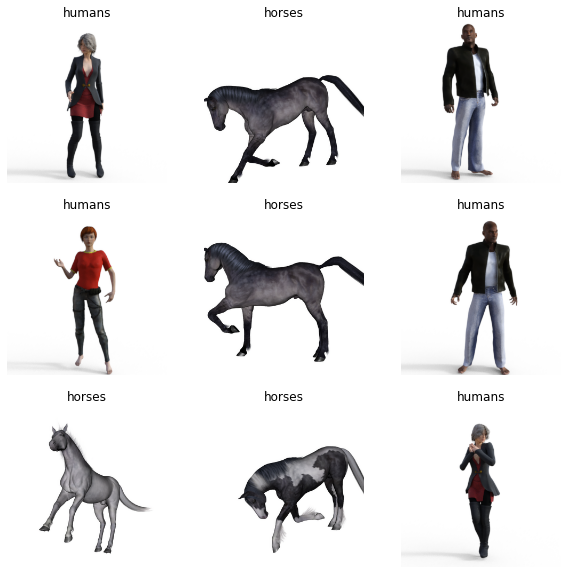

In [40]:

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i+9].astype("uint8"))
  plt.title(get_label_name(predictions[i+9]))

  plt.axis("off")